In [1]:
class AnchorGenerator(object):

    def __init__(self, base_size, scales, ratios, scale_major=True, ctr=None):
        self.base_size = base_size
        self.scales = torch.Tensor(scales)
        self.ratios = torch.Tensor(ratios)
        self.scale_major = scale_major
        self.ctr = ctr
        self.base_anchors = self.gen_base_anchors()

    @property
    def num_base_anchors(self):
        return self.base_anchors.size(0)

    def gen_base_anchors(self):
        w = self.base_size
        h = self.base_size
        if self.ctr is None:
            x_ctr = 0.5 * (w - 1)
            y_ctr = 0.5 * (h - 1)
        else:
            x_ctr, y_ctr = self.ctr

        h_ratios = torch.sqrt(self.ratios)
        w_ratios = 1 / h_ratios
        if self.scale_major:
            ws = (w * w_ratios[:, None] * self.scales[None, :]).view(-1)
            hs = (h * h_ratios[:, None] * self.scales[None, :]).view(-1)
        else:
            ws = (w * self.scales[:, None] * w_ratios[None, :]).view(-1)
            hs = (h * self.scales[:, None] * h_ratios[None, :]).view(-1)

        base_anchors = torch.stack(
            [
                x_ctr - 0.5 * (ws - 1), y_ctr - 0.5 * (hs - 1),
                x_ctr + 0.5 * (ws - 1), y_ctr + 0.5 * (hs - 1)
            ],
            dim=-1).round()

        return base_anchors

    def _meshgrid(self, x, y, row_major=True):
        xx = x.repeat(len(y))
        yy = y.view(-1, 1).repeat(1, len(x)).view(-1)
        if row_major:
            return xx, yy
        else:
            return yy, xx

    def grid_anchors(self, featmap_size, stride=16, device='cuda'):
        base_anchors = self.base_anchors.to(device)

        feat_h, feat_w = featmap_size
        shift_x = torch.arange(0, feat_w, device=device) * stride
        shift_y = torch.arange(0, feat_h, device=device) * stride
        shift_xx, shift_yy = self._meshgrid(shift_x, shift_y)
        shifts = torch.stack([shift_xx, shift_yy, shift_xx, shift_yy], dim=-1)
        shifts = shifts.type_as(base_anchors)
        # first feat_w elements correspond to the first row of shifts
        # add A anchors (1, A, 4) to K shifts (K, 1, 4) to get
        # shifted anchors (K, A, 4), reshape to (K*A, 4)

        all_anchors = base_anchors[None, :, :] + shifts[:, None, :]
        all_anchors = all_anchors.view(-1, 4)
        # first A rows correspond to A anchors of (0, 0) in feature map,
        # then (0, 1), (0, 2), ...
        return all_anchors

    def valid_flags(self, featmap_size, valid_size, device='cuda'):
        feat_h, feat_w = featmap_size
        valid_h, valid_w = valid_size
        assert valid_h <= feat_h and valid_w <= feat_w
        valid_x = torch.zeros(feat_w, dtype=torch.uint8, device=device)
        valid_y = torch.zeros(feat_h, dtype=torch.uint8, device=device)
        valid_x[:valid_w] = 1
        valid_y[:valid_h] = 1
        valid_xx, valid_yy = self._meshgrid(valid_x, valid_y)
        valid = valid_xx & valid_yy
        valid = valid[:, None].expand(
            valid.size(0), self.num_base_anchors).contiguous().view(-1)
        return valid

In [2]:
def get_anchors(featmap_sizes, anchor_strides, anchor_generators, device='cuda'):
    """Get anchors according to feature map sizes.

    Args:
        featmap_sizes (list[tuple]): Multi-level feature map sizes.
        img_metas (list[dict]): Image meta info.

    Returns:
        tuple: anchors of each image, valid flags of each image
    """
    num_imgs = 1
    num_levels = 1
    img_shape = [512, 512]

    # since feature map sizes of all images are the same, we only compute
    # anchors for one time
    multi_level_anchors = []

    for i in range(num_levels):
        anchors = anchor_generators[i].grid_anchors(
            featmap_sizes[i], anchor_strides[i], device)
        multi_level_anchors.append(anchors)
    anchor_list = [multi_level_anchors for _ in range(num_imgs)]

    # for each image, we compute valid flags of multi level anchors
    valid_flag_list = []
    for i in range(num_imgs):
        multi_level_flags = []
        for i in range(num_levels):
            anchor_stride = anchor_strides[i]
            feat_h, feat_w = featmap_sizes[i]
            h, w = img_shape
            valid_feat_h = min(int(np.ceil(h / anchor_stride)), feat_h)
            valid_feat_w = min(int(np.ceil(w / anchor_stride)), feat_w)
            flags = anchor_generators[i].valid_flags(
                (feat_h, feat_w), (valid_feat_h, valid_feat_w), device)
            multi_level_flags.append(flags)
        valid_flag_list.append(multi_level_flags)

    return anchor_list, valid_flag_list

In [3]:
def assign_wrt_overlaps(overlaps, gt_labels=None):
    """Assign w.r.t. the overlaps of bboxes with gts.

    Args:
        overlaps (Tensor): Overlaps between k gt_bboxes and n bboxes,
            shape(k, n).
        gt_labels (Tensor, optional): Labels of k gt_bboxes, shape (k, ).

    Returns:
        :obj:`AssignResult`: The assign result.
    """
    
    pos_iou_thr = 0.5
    neg_iou_thr = 0.4
    min_pos_iou = 0
    gt_max_assign_all = True
    
    if overlaps.numel() == 0:
        raise ValueError('No gt or proposals')

    num_gts, num_bboxes = overlaps.size(0), overlaps.size(1)

    # 1. assign -1 by default
    assigned_gt_inds = overlaps.new_full(
        (num_bboxes, ), -1, dtype=torch.long)

    # for each anchor, which gt best overlaps with it
    # for each anchor, the max iou of all gts
    max_overlaps, argmax_overlaps = overlaps.max(dim=0)
    # for each gt, which anchor best overlaps with it
    # for each gt, the max iou of all proposals
    gt_max_overlaps, gt_argmax_overlaps = overlaps.max(dim=1)

    # 2. assign negative: below
    if isinstance(neg_iou_thr, float):
        assigned_gt_inds[(max_overlaps >= 0)
                         & (max_overlaps < neg_iou_thr)] = 0
    elif isinstance(neg_iou_thr, tuple):
        assert len(neg_iou_thr) == 2
        assigned_gt_inds[(max_overlaps >= neg_iou_thr[0])
                         & (max_overlaps < neg_iou_thr[1])] = 0

    # 3. assign positive: above positive IoU threshold
    pos_inds = max_overlaps >= pos_iou_thr
    assigned_gt_inds[pos_inds] = argmax_overlaps[pos_inds] + 1

    # 4. assign fg: for each gt, proposals with highest IoU
    for i in range(num_gts):
        if gt_max_overlaps[i] >= min_pos_iou:
            if gt_max_assign_all:
                max_iou_inds = overlaps[i, :] == gt_max_overlaps[i]
                assigned_gt_inds[max_iou_inds] = i + 1
            else:
                assigned_gt_inds[gt_argmax_overlaps[i]] = i + 1

    if gt_labels is not None:
        assigned_labels = assigned_gt_inds.new_zeros((num_bboxes, ))
        pos_inds = torch.nonzero(assigned_gt_inds > 0).squeeze()
        if pos_inds.numel() > 0:
            assigned_labels[pos_inds] = gt_labels[
                assigned_gt_inds[pos_inds] - 1]
    else:
        assigned_labels = None
        
    return num_gts, assigned_gt_inds, max_overlaps

def bbox_overlaps(bboxes1, bboxes2, mode='iou', is_aligned=False):
    """Calculate overlap between two set of bboxes.

    If ``is_aligned`` is ``False``, then calculate the ious between each bbox
    of bboxes1 and bboxes2, otherwise the ious between each aligned pair of
    bboxes1 and bboxes2.

    Args:
        bboxes1 (Tensor): shape (m, 4)
        bboxes2 (Tensor): shape (n, 4), if is_aligned is ``True``, then m and n
            must be equal.
        mode (str): "iou" (intersection over union) or iof (intersection over
            foreground).

    Returns:
        ious(Tensor): shape (m, n) if is_aligned == False else shape (m, 1)
    """

    assert mode in ['iou', 'iof']

    rows = bboxes1.size(0)
    cols = bboxes2.size(0)
    if is_aligned:
        assert rows == cols

    if rows * cols == 0:
        return bboxes1.new(rows, 1) if is_aligned else bboxes1.new(rows, cols)

    if is_aligned:
        lt = torch.max(bboxes1[:, :2], bboxes2[:, :2])  # [rows, 2]
        rb = torch.min(bboxes1[:, 2:], bboxes2[:, 2:])  # [rows, 2]

        wh = (rb - lt + 1).clamp(min=0)  # [rows, 2]
        overlap = wh[:, 0] * wh[:, 1]
        area1 = (bboxes1[:, 2] - bboxes1[:, 0] + 1) * (
            bboxes1[:, 3] - bboxes1[:, 1] + 1)

        if mode == 'iou':
            area2 = (bboxes2[:, 2] - bboxes2[:, 0] + 1) * (
                bboxes2[:, 3] - bboxes2[:, 1] + 1)
            ious = overlap / (area1 + area2 - overlap)
        else:
            ious = overlap / area1
    else:
        lt = torch.max(bboxes1[:, None, :2], bboxes2[:, :2])  # [rows, cols, 2]
        rb = torch.min(bboxes1[:, None, 2:], bboxes2[:, 2:])  # [rows, cols, 2]

        wh = (rb - lt + 1).clamp(min=0)  # [rows, cols, 2]
        overlap = wh[:, :, 0] * wh[:, :, 1]
        area1 = (bboxes1[:, 2] - bboxes1[:, 0] + 1) * (
            bboxes1[:, 3] - bboxes1[:, 1] + 1)

        if mode == 'iou':
            area2 = (bboxes2[:, 2] - bboxes2[:, 0] + 1) * (
                bboxes2[:, 3] - bboxes2[:, 1] + 1)
            ious = overlap / (area1[:, None] + area2 - overlap)
        else:
            ious = overlap / (area1[:, None])

    return ious


In [4]:
def bbox2delta(proposals, gt, means=[0, 0, 0, 0], stds=[1, 1, 1, 1]):
    assert proposals.size() == gt.size()

    proposals = proposals.float()
    gt = gt.float()
    px = (proposals[..., 0] + proposals[..., 2]) * 0.5
    py = (proposals[..., 1] + proposals[..., 3]) * 0.5
    pw = proposals[..., 2] - proposals[..., 0] + 1.0
    ph = proposals[..., 3] - proposals[..., 1] + 1.0

    gx = (gt[..., 0] + gt[..., 2]) * 0.5
    gy = (gt[..., 1] + gt[..., 3]) * 0.5
    gw = gt[..., 2] - gt[..., 0] + 1.0
    gh = gt[..., 3] - gt[..., 1] + 1.0

    dx = (gx - px) / pw
    dy = (gy - py) / ph
    dw = torch.log(gw / pw)
    dh = torch.log(gh / ph)
    deltas = torch.stack([dx, dy, dw, dh], dim=-1)

    means = deltas.new_tensor(means).unsqueeze(0)
    stds = deltas.new_tensor(stds).unsqueeze(0)
    deltas = deltas.sub_(means).div_(stds)

    return deltas

def delta2bbox(rois,
               deltas,
               means=[0, 0, 0, 0],
               stds=[1, 1, 1, 1],
               max_shape=None):
    means = deltas.new_tensor(means).repeat(1, deltas.size(1) // 4)
    stds = deltas.new_tensor(stds).repeat(1, deltas.size(1) // 4)
    denorm_deltas = deltas * stds + means
    dx = denorm_deltas[:, 0::4]
    dy = denorm_deltas[:, 1::4]
    dw = denorm_deltas[:, 2::4]
    dh = denorm_deltas[:, 3::4]
    px = ((rois[:, 0] + rois[:, 2]) * 0.5).unsqueeze(1).expand_as(dx)
    py = ((rois[:, 1] + rois[:, 3]) * 0.5).unsqueeze(1).expand_as(dy)
    pw = (rois[:, 2] - rois[:, 0] + 1.0).unsqueeze(1).expand_as(dw)
    ph = (rois[:, 3] - rois[:, 1] + 1.0).unsqueeze(1).expand_as(dh)
    gw = pw * dw.exp()
    gh = ph * dh.exp()
    gx = torch.addcmul(px, 1, pw, dx)  # gx = px + pw * dx
    gy = torch.addcmul(py, 1, ph, dy)  # gy = py + ph * dy
    x1 = gx - gw * 0.5 + 0.5
    y1 = gy - gh * 0.5 + 0.5
    x2 = gx + gw * 0.5 - 0.5
    y2 = gy + gh * 0.5 - 0.5
    if max_shape is not None:
        x1 = x1.clamp(min=0, max=max_shape[1] - 1)
        y1 = y1.clamp(min=0, max=max_shape[0] - 1)
        x2 = x2.clamp(min=0, max=max_shape[1] - 1)
        y2 = y2.clamp(min=0, max=max_shape[0] - 1)
    bboxes = torch.stack([x1, y1, x2, y2], dim=-1).view_as(deltas)
    return bboxes

In [161]:
def prepare_base_figure(shape, grid_size, figsize=(20, 20)):    
    fig, ax = plt.subplots(figsize=figsize)

    loc = plticker.MultipleLocator(base=grid_size)
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)
    
    ax.grid(which='major', axis='both', linestyle='--', color='w')
    return ax 


def draw_anchor_gt_overlaps(overlaps, grid_size=1, figsize=(20, 20)):    
    """Draw anchor overlaps w.r.t. gt bboxes"""
    grid_x, grid_y = overlaps.shape[:2]
    ax = prepare_base_figure(overlaps.shape, grid_size, figsize)
    ax.imshow(overlaps, extent=[0, grid_x, 0, grid_y])
    plt.margins(0)
    plt.show()

    
def draw_pos_assigned_bboxes(image_shape, grid_size, gt_bboxes_list, pos_bboxes, 
                             pos_pred_bboxes=None, figsize=(20, 20)):
    """Draw positive, negative bboxes."""
    background_image = np.zeros(image_shape)
    ax = prepare_base_figure(image_shape, grid_size, figsize)
    
    for gt_bbox in gt_bboxes_list:
        x1, y1, x2, y2 = gt_bbox
        cv2.rectangle(background_image, (x1, y1), (x2, y2), (0, 0, 255), 1)
        
    for pos_bbox in pos_bboxes:
        x1, y1, x2, y2 = pos_bbox
        cv2.rectangle(background_image, (x1, y1), (x2, y2), (0, 255, 0), 1)
    
    if pos_pred_bboxes is not None:
        for pos_pred_bbox in pos_pred_bboxes:
            x1, y1, x2, y2 = pos_pred_bbox
            cv2.rectangle(background_image, (x1, y1), (x2, y2), (255, 0, 0), 1)
    
    image_x, image_y = image_shape[:2]
    ax.imshow(background_image, extent=[0, image_x, 0, image_y])        
    plt.show()

    
# assume our anchor_head network predicted delta
def predict_anchor(shape):
    delta_pred = torch.randn([9216, 4])
    return delta_pred

In [162]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

# parameters
base_size = 16
anchor_strides = [16]
scales = [2, 4, 8]
ratios = [0.5, 1.0, 2.0]

featmap_sizes = [[32, 32]]
device = 'cpu'
image_shape = [512, 512, 3]

In [163]:
# anchors
anchor_generators = [AnchorGenerator(base_size=base_size, scales=scales, ratios=ratios)]
anchor_list, valid_flag_list = get_anchors(featmap_sizes, anchor_strides, anchor_generators, 'cpu')
anchor_list, valid_flag_list = anchor_list[0][0], valid_flag_list[0][0]

# check valid_flag_list
print(valid_flag_list.all())

# set label
gt_bboxes_list = torch.FloatTensor([[5, 5, 45, 45]]).to(device)

tensor(1, dtype=torch.uint8)


In [164]:
flat_anchors = anchor_list[:, :4]
overlaps = bbox_overlaps(gt_bboxes_list, flat_anchors)
overlaps_npy = overlaps.reshape(32, 32, 9).cpu().numpy()

# assigned result
# gt_inds == assigned_gt_inds
num_gts, assigned_gt_inds, max_overlaps = assign_wrt_overlaps(overlaps)
pos_inds = torch.nonzero(assigned_gt_inds > 0).squeeze(-1).unique()  # positive
neg_inds = torch.nonzero(assigned_gt_inds == 0).squeeze(-1).unique()  # negative 
bboxes = anchor_list  # bboxes
pos_bboxes = bboxes[pos_inds]
pos_assigned_gt_inds = assigned_gt_inds[pos_inds] - 1
pos_gt_bboxes = gt_bboxes_list[pos_assigned_gt_inds, :]
target_deltas = bbox2delta(pos_bboxes, pos_gt_bboxes)

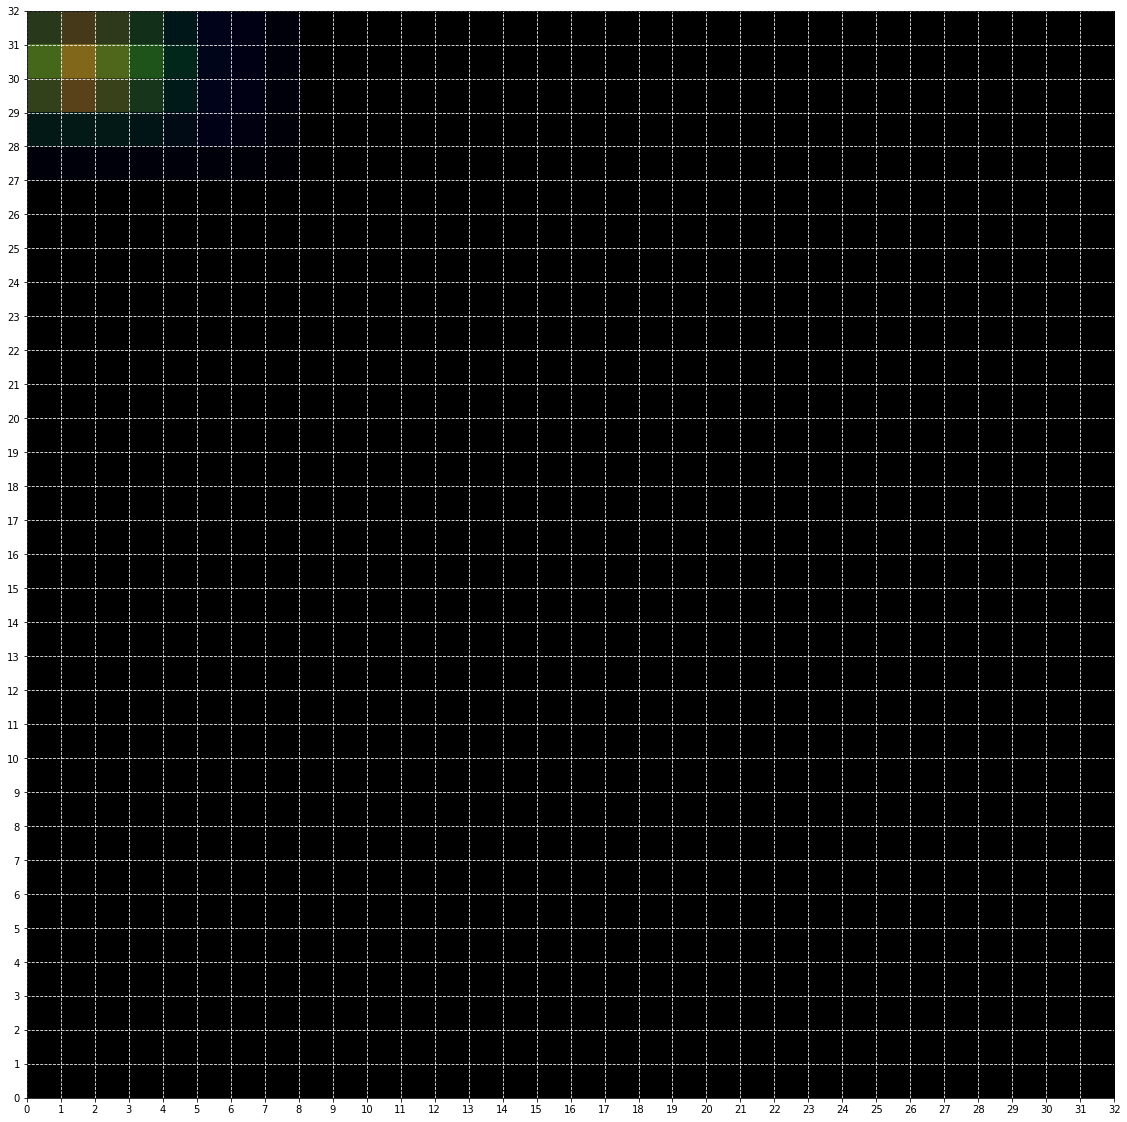

In [165]:
# grid cross point = pixel value
draw_anchor_gt_overlaps(overlaps_npy[..., :3])

In [166]:
# check if delta has same bbox value when reversed
bboxes_reversed = delta2bbox(pos_bboxes, target_deltas)
assert torch.equal(bboxes_reversed[0], gt_bboxes_list[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


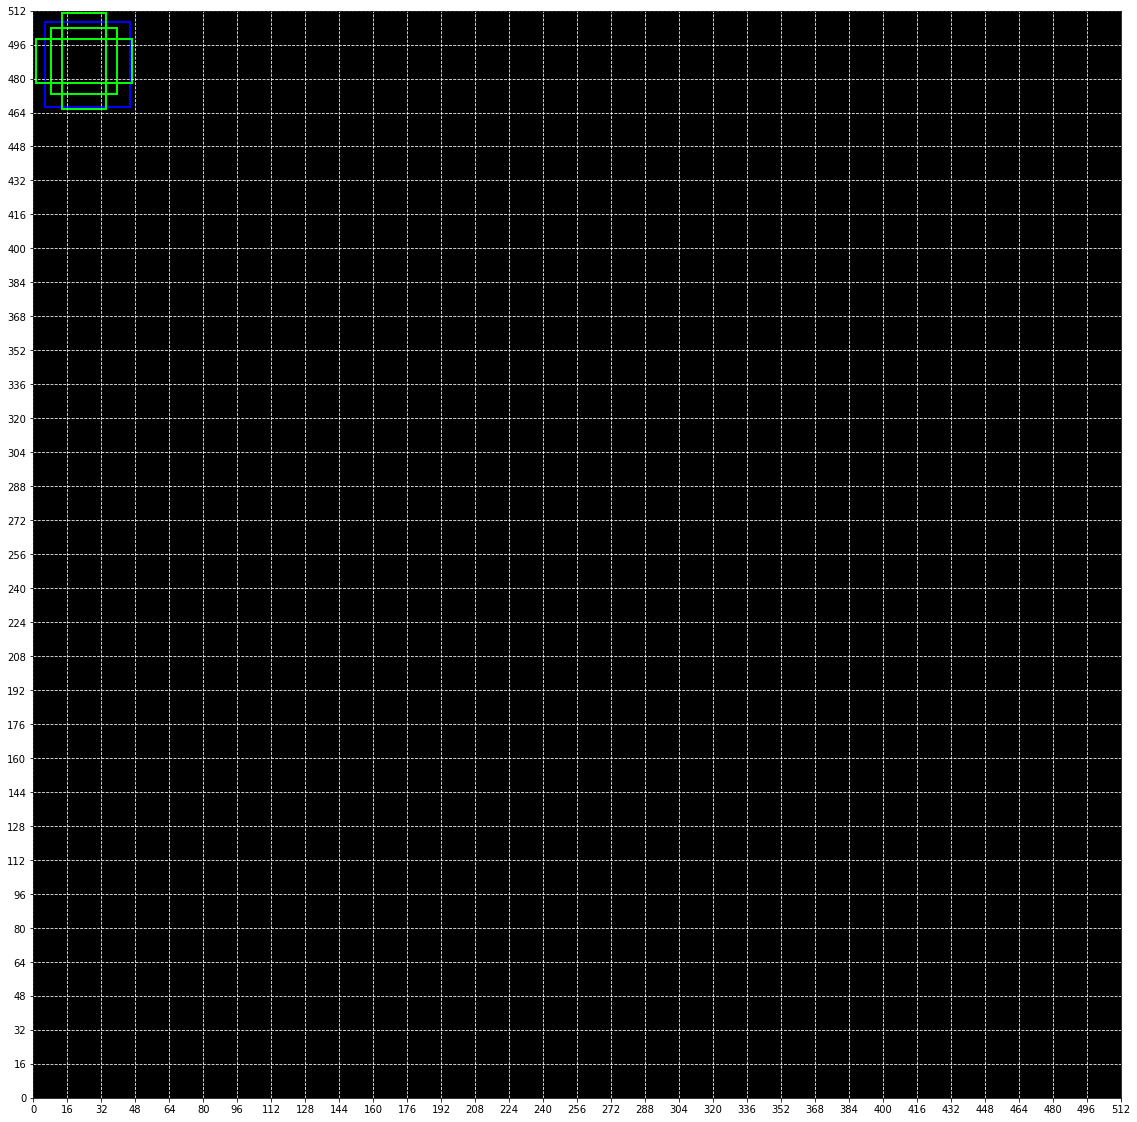

In [167]:
draw_pos_assigned_bboxes(image_shape, base_size, gt_bboxes_list, pos_bboxes)

In [168]:
torch.manual_seed(0)

In [169]:
delta_pred = predict_anchor(flat_anchors.shape)

In [170]:
pos_delta_pred = delta_pred[pos_inds]

In [172]:
pos_bboxes_pred = delta2bbox(pos_bboxes, pos_delta_pred, max_shape=(512, 512))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


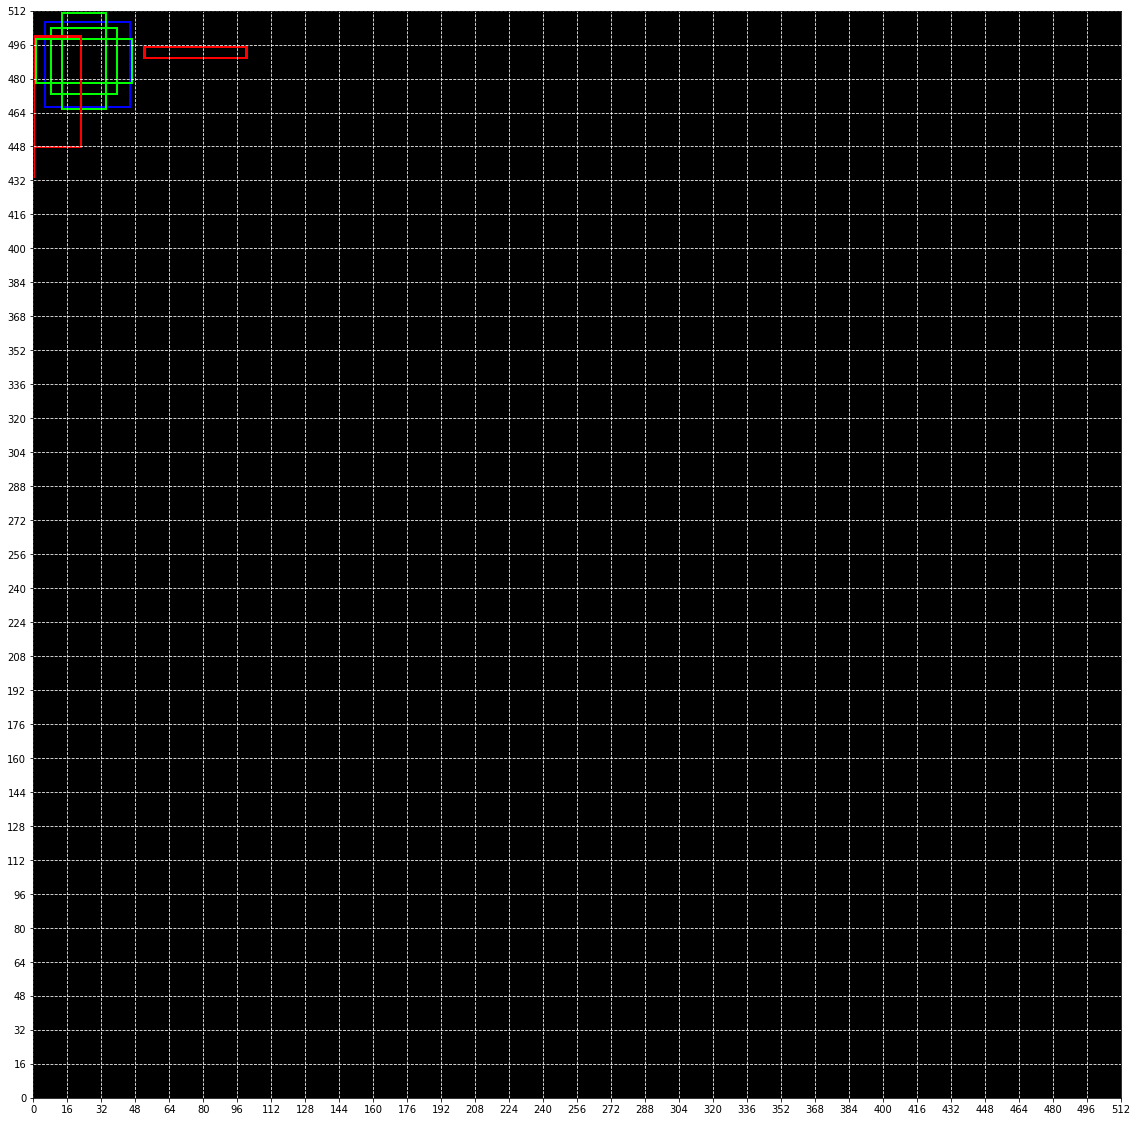

In [173]:
draw_pos_assigned_bboxes(image_shape, base_size, gt_bboxes_list, pos_bboxes, pos_bboxes_pred)